In [1]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import svm
import itertools 
import numpy as np
from numba import vectorize, complex64, boolean, jit
import os, sys, itertools, time
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

## Creating and loading Julia sets

(11970, 4) (11970,) (63, 95)
[-2.         -1.         -0.12584225  0.05355327] [-1.95822454 -1.         -0.12584225  0.05355327]


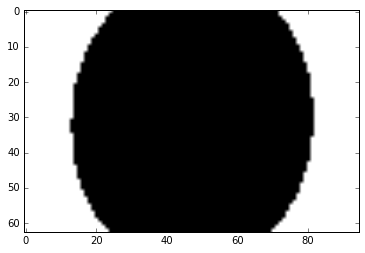

In [2]:
@jit
def load_array(filename, prefix="data/"):
    filename = prefix + filename
    return np.load(filename)

@jit
def f(z, c):   #iterating function
    return z * z + c

@jit
def does_diverge(z, c, iters):  #checks if a given pixel diverges
    for _ in range(iters):
        z = f(z, c)
        if abs(z) > 2: # Diverges
            return 1
    return 0

def generate_julia_set(size, numIter, c=False):
    x = np.linspace(-2, 2, size * 3)
    y = np.linspace(-1, 1, size * 2)
    X = np.array(list(itertools.product(y, x)))[:, (1, 0)]
    if not c:
        output = np.array([does_diverge(complex(*sample), complex(*sample), numIter) for sample in X])
    else:
        output = np.array([does_diverge(complex(*sample), c, numIter) for sample in X])
    
    return X, output.reshape((size * 2, size * 3)) #image format

def subSample(anArray, reductionFactor, shouldDraw=False):
    #Note that reductionFactor is a float between 0 and 1
    #Also note reductionFactor is per dimension (so for us, the true size reduction is
    #   reductionFactor squared)
    xSamples = np.linspace(0,255,int(255*reductionFactor),dtype=int)
    ySamples = np.linspace(0,383,int(383*reductionFactor),dtype=int)
    ans = anArray[np.ix_(xSamples, ySamples)]
    if shouldDraw:
        plt.figure()
        plt.imshow(ans, cmap="gray")
        plt.figure()
        plt.imshow(anArray, cmap="gray")
    return ans

def loadTask(whichSamples, theFactor):
    txt = open("data/meta/cvalues.txt")
    X_ab= load_array("X_abvalues.npy")
    X_ab = X_ab.reshape(256, 384, 2)
    X_ab = subSample(X_ab, theFactor)
    image_size = X_ab.shape[:2]
    X_ab = X_ab.reshape((X_ab.shape[0]*X_ab.shape[1]), 2)
    X = []
    Y = []
    for desc, imgnum in zip(txt, whichSamples): #2151+1 since top range is exclusive
        Fname, a, b = desc.split()
        b = b[:-1] # remove the 'i' at the end
        
        _, arr = generate_julia_set(128, 1, c=float(a)+float(b)*1j)
        
        arr = subSample(arr, theFactor)
        arr = np.ndarray.flatten(arr)
        Y.extend(arr)
        for coord in X_ab:
            a, b = float(a), float(b)
            X.append([float(coord[0]), float(coord[1]), a, b])
    return np.array(X), np.array(Y), image_size

a = -.1
b = 0.9
# X, y = generate_julia_set(128, 1, c=a+b*1j) #c=-1+0.2j is a decent value
factor = 0.25
X, y, smallShape = loadTask([0, 1], factor)
print(X.shape, y.shape, smallShape)
print(X[0], X[1])
plt.imshow(y[:smallShape[0]*smallShape[1]].reshape(smallShape), cmap = 'gray')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8019, 4) (3951, 4) (8019,) (3951,)


## Predicting Divergence based off x, y, and c values

In [4]:
######Start Error Functions#######
def getSquaredError(sklearnModel, xTest, yTest):
    preds = sklearnModel.predict(xTest)
    squaredError = np.linalg.norm(preds)**2
    return squaredError/len(yTest)

def getClassificationError(sklearnModel, xTest, yTest):
    preds = sklearnModel.predict(xTest)
    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    err = np.mean(np.where(preds == yTest, 0, 1))
    return err
######End Error Functions#######

######Start ols Preprocessing#######
def singleIterPreprocess(xData):
    print("Special preprocessing")
    featxData = []
    for aRow in xData:
        x, y, a, b = aRow[0], aRow[1], aRow[2], aRow[3]
        tmp = [1, (x**2 - y**2 + a)**2, (2*x*y + b)**2] #(x**2 - y**2 + a)*(2*x*y + b)
#         tmp = [x, y, a, b]
        featxData.append(tmp)
    featxData = np.array(featxData)
#     poly = PolynomialFeatures(degree=4)
#     featxData = poly.fit_transform(featxData)
    return featxData

def olsPreprocessX(xData, theDegree):
    poly = PolynomialFeatures(degree=theDegree)
    featxData = poly.fit_transform(xData)
    return featxData
######End ols Preprocessing#######

##################################
def visualize(sklearnModel, featxData):
    yData = sklearnModel.predict(featxData)
    yData[yData < .5] = 0
    yData[yData >=.5] = 1
    if np.min(yData) == np.max(yData):
        print("Got only " + str(np.min(yData)))
    plt.figure()
    plt.imshow(yData.reshape(smallShape), cmap="gray")
##################################


def ols(xTrain, yTrain, xTest, yTest, theDegree, vizDataset, shouldVisualize=False):
    if theDegree:
        preProcFunc = lambda x: olsPreprocessX(x, theDegree)
    else:
        preProcFunc = lambda x: singleIterPreprocess(x)
        
    xTrain = preProcFunc(xTrain)
    xTest = preProcFunc(xTest)

##     List of possible models
#     reg = linear_model.LinearRegression()
#     reg = kernel_ridge.KernelRidge(kernel="rbf") 
#     reg = svm.SVC(kernel="rbf")  #class_weight={0:0.9, 1:0.1}
#     kernel="rbf", kernel="sigmoid", kernel="polynomial", degree=5
    reg = linear_model.LogisticRegression()

    reg.fit(xTrain, yTrain)
    trainError = getClassificationError(reg, xTrain, yTrain) 
    testError = getClassificationError(reg, xTest, yTest)
    
    if shouldVisualize:
        xData = preProcFunc(vizDataset)
        visualize(reg, xData)

    return trainError, testError, reg, preProcFunc

def ridgeClassification(x, y, lmbdas):
    xTrain, yTrain = olsPreprocess(xTrain, yTrain)
    xTrain, yTrain = olsPreprocess(xTest, yTest)

    #Preprocess before hand!
    trainErrors = []
    testErrors = []
    for aLmbda in lmbdas:
        reg = linear_model.RidgeCV(alphas=aLmbda) #Should pass in apropriate k for CV
        reg.fit(xTrain, yTrain)
        aTrainError = getSquaredError(reg, xTrain, yTrain) 
        aTestError = getSquaredError(reg, xTest, yTest)
        trainErrors.append(aTrainError)
        testErrors.append(aTestError)

    return trainErrors, testErrors

Special preprocessing
Special preprocessing
Special preprocessing


(0.00087292679885272474,
 0.0012655024044545685,
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 <function __main__.ols.<locals>.<lambda>>)

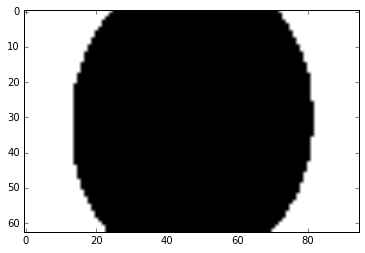

In [5]:
ols(X_train, y_train, X_test, y_test, None, X[:smallShape[0]*smallShape[1]], shouldVisualize=True)

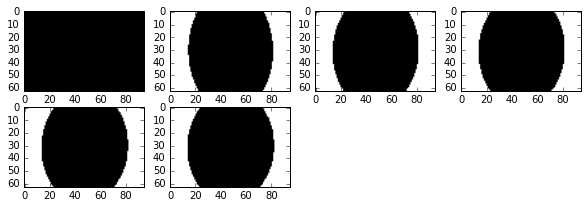

In [6]:
plt.figure(figsize=(10,10))
for i in range(1, 7, 1):
    trainErr, testErr, theModel, preProcessFn = \
        ols(X_train, y_train, X_test, y_test, i, None, shouldVisualize=False)

    tmp = preProcessFn(X[:smallShape[0]*smallShape[1]])
    
    yData = theModel.predict(tmp)
    yData[yData < .5] = 0
    yData[yData >=.5] = 1
    plt.subplot(6,4,i)
    plt.imshow(yData.reshape(smallShape), cmap="gray")